In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
tracts_path = "../data/tabblock2010_04_pophu/tabblock2010_04_pophu.shp"

census_tracts_az = gd.read_file(tracts_path)


tribal_areas_path = '../data/tl_2019_us_aiannh/tl_2019_us_aiannh.shp'

tribal_areas = gd.read_file(tribal_areas_path)
tribal_areas.set_index('AIANNHCE', inplace=True)

# 1505 is the AIANNHCE ID of the Hopi reservation
# from https://www2.census.gov/geo/docs/reference/codes/AIAlist.txt
hopi = tribal_areas.loc["1505"]

census_tracts_hopi = gd.overlay(hopi, census_tracts_az, how="intersection")
census_tracts_hopi = census_tracts_hopi.set_index('BLOCKID10')

In [3]:
skyhook_col_types = {
    "tide5id_100m" : str,
    "mac_oui" : str,
    "ssid" : str,
    "lat" : float,
    "lon" : float ,
    "rq_time" : str, # we parse this as date with parse_dates parameter in read_csv call later
    "zcta" : int,
    "zcta_city" : str,
    "zcta_county" : str,
    "zcta_state" : str
}

skyhook_data = pd.read_csv("../data/skyhook/p1059_nau_oui_20210301.csv", dtype=skyhook_col_types, parse_dates=['rq_time'])
skyhook_gdf = gd.GeoDataFrame(skyhook_data, geometry=gd.points_from_xy(skyhook_data.lon, skyhook_data.lat)).set_crs("EPSG:4326").to_crs(hopi.crs)
skyhook_hopi = gd.overlay(skyhook_gdf, hopi, how="intersection")

In [4]:
fcc_477_col_types = {
    'LogRecNo': int, 
    'Provider_Id': int, 
    'FRN': int, 
    'ProviderName': str,
    'DBAName': str,
    'HoldingCompanyName' : str,
    'HocoNum' : int,
    'HocoFinal': str,
    'StateAbbr' : str,
    'BlockCode' : str, # this really is a string, not a number. Leading 0s have meaning
    'TechCode' : int,
    'Consumer' : bool ,
    'MaxAdDown' : float,
    'MaxAdUp' : float ,
    'Business' : bool
}

fcc_477 = pd.read_csv('../data/AZ-Fixed-Jun2020/AZ-Fixed-Jun2020-v1.csv', dtype=fcc_477_col_types)

In [5]:
hopi_fcc_477 = fcc_477[fcc_477['BlockCode'].isin(census_tracts_hopi.index)]
hopi_fcc_477['BlockCode'].describe()

count               17242
unique               3595
top       040059449002053
freq                    8
Name: BlockCode, dtype: object

100% of census blocks are serviced by satellite internet providers, so analysis of space serviced by other forms of providers is more interesting. 

In [6]:
hopi_fcc_477_no_sat = hopi_fcc_477.loc[lambda df: df['TechCode'] != 60]
hopi_fcc_477_no_sat['BlockCode'].describe()

count                2913
unique               2823
top       040059449002152
freq                    4
Name: BlockCode, dtype: object

It is also interesting to look at this data without terrestrial fixed wireless being included.

In [7]:
hopi_fcc_477_no_wireless = hopi_fcc_477_no_sat.loc[lambda df: df['TechCode'] != 70]
hopi_fcc_477_no_wireless['BlockCode'].describe()

count                  88
unique                 35
top       040059449002038
freq                    3
Name: BlockCode, dtype: object

In [8]:
census_tracts_hopi['477_evidence'] = census_tracts_hopi.index.isin(hopi_fcc_477['BlockCode'])
census_tracts_hopi['no_sat_477_evidence'] = census_tracts_hopi.index.isin(hopi_fcc_477_no_sat['BlockCode'])
census_tracts_hopi['no_wireless_477_evidence'] = census_tracts_hopi.index.isin(hopi_fcc_477_no_wireless['BlockCode'])

In [9]:
fcc_477_fixed_wireless_evidence_blocks = census_tracts_hopi.loc[census_tracts_hopi['no_sat_477_evidence']]
fcc_477_evidence_blocks = census_tracts_hopi.loc[census_tracts_hopi['no_wireless_477_evidence']]

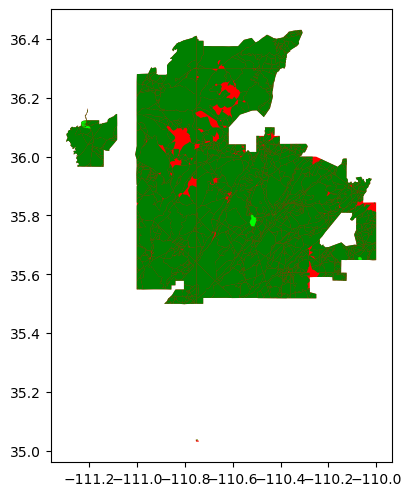

In [10]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

ax.set_aspect('equal')
hopi.plot(ax=ax, color='red')
fcc_477_fixed_wireless_evidence_blocks.plot(ax=ax, color='green')
fcc_477_evidence_blocks.plot(ax=ax, color='lime')
plt.show()

In [11]:
skyhook_hopi_joined = gd.sjoin(skyhook_hopi, census_tracts_hopi, how='left', op='within')

In [12]:
skyhook_hopi_joined['index_right'].describe()

count                9403
unique                449
top       040179400133946
freq                  733
Name: index_right, dtype: object

In [13]:
census_tracts_hopi['skyhook_evidence'] = census_tracts_hopi.index.isin(skyhook_hopi_joined['index_right'])

In [14]:
skyhook_evidence_blocks = census_tracts_hopi.loc[census_tracts_hopi['skyhook_evidence']]

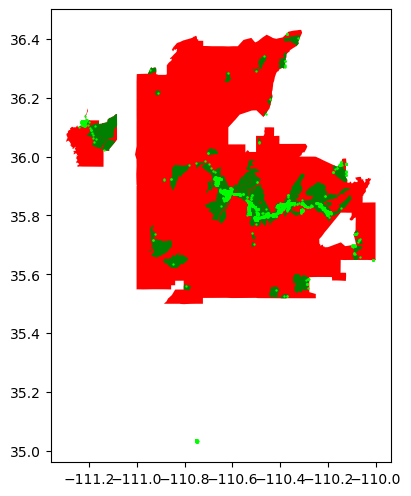

In [15]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

ax.set_aspect('equal')
hopi.plot(ax=ax, color='red')
skyhook_evidence_blocks.plot(ax=ax, color='green')
skyhook_hopi.plot(ax=ax, color='lime', markersize=.5)
plt.show()

In [39]:
eoc_both = census_tracts_hopi[(census_tracts_hopi['skyhook_evidence']) & (census_tracts_hopi['no_wireless_477_evidence'])]
eoc_neither = census_tracts_hopi[(~census_tracts_hopi['skyhook_evidence']) & (~census_tracts_hopi['no_wireless_477_evidence'])]
eoc_skyhook = census_tracts_hopi[(census_tracts_hopi['skyhook_evidence']) & (~census_tracts_hopi['no_wireless_477_evidence'])]
eoc_fcc = census_tracts_hopi[(~census_tracts_hopi['skyhook_evidence']) & (census_tracts_hopi['no_wireless_477_evidence'])]

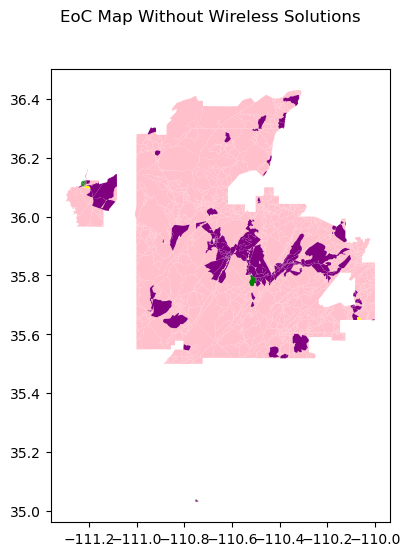

In [40]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

ax.set_aspect('equal')
eoc_both.plot(ax=ax, color='green')
eoc_neither.plot(ax=ax, color='pink')
eoc_skyhook.plot(ax=ax, color='purple')
eoc_fcc.plot(ax=ax, color='yellow')
plt.suptitle('EoC Map Without Wireless Solutions')
plt.show()

In [42]:
eoc_both = census_tracts_hopi[(census_tracts_hopi['skyhook_evidence']) & (census_tracts_hopi['no_sat_477_evidence'])]
eoc_neither = census_tracts_hopi[(~census_tracts_hopi['skyhook_evidence']) & (~census_tracts_hopi['no_sat_477_evidence'])]
eoc_skyhook = census_tracts_hopi[(census_tracts_hopi['skyhook_evidence']) & (~census_tracts_hopi['no_sat_477_evidence'])]
eoc_fcc = census_tracts_hopi[(~census_tracts_hopi['skyhook_evidence']) & (census_tracts_hopi['no_sat_477_evidence'])]

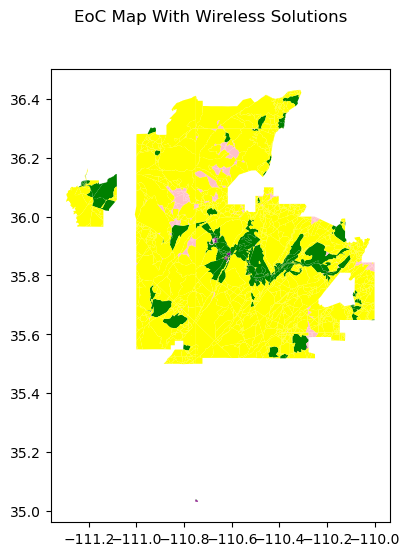

In [43]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

ax.set_aspect('equal')
eoc_both.plot(ax=ax, color='green')
eoc_neither.plot(ax=ax, color='pink')
eoc_skyhook.plot(ax=ax, color='purple')
eoc_fcc.plot(ax=ax, color='yellow')
plt.suptitle('EoC Map With Wireless Solutions')
plt.show()